In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.linalg import lu_factor, lu_solve
import time 

In [2]:
!pip install scikit-gstat

In [3]:
#lat_lon_np = pd.read_csv('gs://kriging2/509_101408/X_train.csv', header=None).to_numpy()[1:]
#altitude_np_arr = pd.read_csv('gs://kriging2/509_101408/y_train.csv', header=None).to_numpy()[1:]
# grid_rdd = sc.textFile('gs://kriging/203_101714/X_test.csv')
#grid_df = spark.read.option('header', True).csv('gs://kriging2/509_101408/X_test.csv')

In [4]:
lat_lon_np = pd.read_csv('gs://kriging2/polish_data/polish_data_2023-03-04-17.csv')[['lat', 'lon']].values
altitude_np_arr = pd.read_csv('gs://kriging2/polish_data/polish_data_2023-03-04-17.csv')['temp'].values
grid_df = spark.read.option('header', True).csv('gs://kriging2/polish_data/grid_1920x1080.csv')

In [5]:
grid_rdd = grid_df.rdd.map(lambda x: (int(x[0]), (float(x[1]), float(x[2]))))
grid_rdd = grid_rdd.repartition(8)
grid_rdd.collect()

23/05/14 14:20:07 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1684073816951_0001_01_000002 on host: spark-min-m.europe-central2-c.c.clear-veld-305923.internal. Exit status: 137. Diagnostics: [2023-05-14 14:20:06.903]Container killed on request. Exit code is 137
[2023-05-14 14:20:06.907]Container exited with a non-zero exit code 137. 
[2023-05-14 14:20:06.928]Killed by external signal
.
23/05/14 14:20:07 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 2 for reason Container from a bad node: container_1684073816951_0001_01_000002 on host: spark-min-m.europe-central2-c.c.clear-veld-305923.internal. Exit status: 137. Diagnostics: [2023-05-14 14:20:06.903]Container killed on request. Exit code is 137
[2023-05-14 14:20:06.907]Container exited with a non-zero exit code 137. 
[2023-05-14 14:20:06.928]Killed by external signal
.
23/05/14 14:20:07 ERROR org.apache.spark.scheduler.cl

[(1094752, (52.16297879729026, 20.71373783438369)),
 (1094753, (52.16297879729026, 20.723025288785912)),
 (1094754, (52.16297879729026, 20.73231274318814)),
 (1094755, (52.16297879729026, 20.741600197590362)),
 (1094756, (52.16297879729026, 20.750887651992585)),
 (1094757, (52.16297879729026, 20.76017510639481)),
 (1094758, (52.16297879729026, 20.769462560797034)),
 (1094759, (52.16297879729026, 20.778750015199257)),
 (1094760, (52.16297879729026, 20.788037469601484)),
 (1094761, (52.16297879729026, 20.797324924003707)),
 (1094832, (52.16297879729026, 21.456734186561633)),
 (1094833, (52.16297879729026, 21.466021640963856)),
 (1094834, (52.16297879729026, 21.47530909536608)),
 (1094835, (52.16297879729026, 21.484596549768305)),
 (1094836, (52.16297879729026, 21.49388400417053)),
 (1094837, (52.16297879729026, 21.50317145857275)),
 (1094838, (52.16297879729026, 21.512458912974978)),
 (1094839, (52.16297879729026, 21.5217463673772)),
 (1094840, (52.16297879729026, 21.531033821779424)),
 

In [6]:
# altitude_np = np.array([float(x[0]) for x in altitude_np_arr])
altitude_np = altitude_np_arr

In [7]:
lat_lon_np = np.array([(float(x[0]), float(x[1])) for x in lat_lon_np])
lat_lon_np

array([[53.127505 , 23.1470509],
       [49.822118 , 19.0448936],
       [53.6999165, 17.5703441],
       [50.8120466, 19.113213 ],
       [54.1558708, 19.4044583],
       [54.4288032, 18.7983259],
       [51.0281551, 18.4222682],
       [54.6066432, 18.8027076],
       [50.9031028, 15.7344306],
       [51.747365 , 18.0795901],
       [50.2598987, 19.0215852],
       [54.0819763, 21.3768281],
       [50.8540359, 20.6099144],
       [50.4337118, 16.6422465],
       [52.2019866, 18.6359912],
       [54.1762116, 15.5764037],
       [54.19092  , 16.17707  ],
       [51.5849678, 21.549883 ],
       [50.0619474, 19.9368564],
       [49.6889843, 21.7534788],
       [51.2047689, 16.174675 ],
       [49.4689014, 22.3303816],
       [51.8436068, 16.5804218],
       [54.5324454, 17.7443951],
       [51.250559 , 22.5701022],
       [54.7604388, 17.5313769],
       [51.7728066, 19.478495 ],
       [53.7981816, 21.5772462],
       [53.1341915, 20.362883 ],
       [49.610304 , 20.7149366],
       [53

### algorithm

<Figure size 640x480 with 0 Axes>

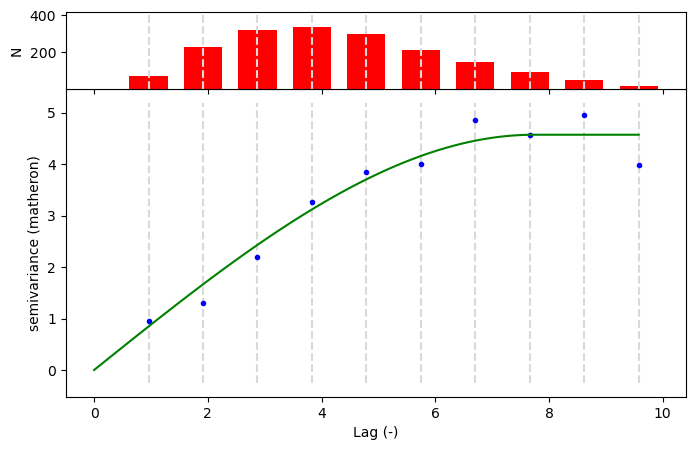

In [13]:
import skgstat as skg
import matplotlib.pyplot as plt

fig = plt.figure()

V = skg.Variogram(coordinates=lat_lon_np, values=altitude_np, n_lags=10, model='spherical')
V.plot()
fig.savefig('./variogram.jpg')
fitted_model = skg.Variogram.fitted_model_function(**V.describe())

In [9]:
V.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 74.02168575232649,
 'normalized_sill': 22.621216480235514,
 'normalized_nugget': 0,
 'effective_range': 7.730316015841868,
 'sill': 4.572508665291849,
 'nugget': 0,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'even',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': False,
  'maxlag': None,
  'n_lags': 10,
  'verbose': False},
 'kwargs': {}}

In [24]:
def cartesian_product(arr):
    l = len(arr)
    cart = np.empty((l ** 2, 4))
    it = 0
    for x in range(len(arr)):
        p1 = arr[x]
        for y in range(len(arr)):
            p2 = arr[y]
            cart[it] = np.concatenate([p1, p2])
            it += 1
    return cart


def add_bias(covariance_vector):
    covariance_vector = np.array([np.append(x, np.double(1.0)) for x in covariance_vector], dtype=np.double)
    ones = np.ones(len(covariance_vector) + 1, dtype=np.double)
    covariance_vector = np.append(covariance_vector, [ones], axis=0)
    return covariance_vector

In [25]:
import scipy
import time
from scipy.spatial import distance


def fit_transform(lat_lon_np, altitude_np, grid_rdd, fitted_model):
    t1_all = time.time()
    t1_master = time.time()
    matrix_size = len(lat_lon_np)
    cartesian = cartesian_product(lat_lon_np)
    distances = np.array([scipy.spatial.distance.euclidean([x[0], x[1]], [x[2], x[3]]) for x in cartesian])
    covariance = np.array([fitted_model(x) for x in distances])
    covariance_matrix = covariance.reshape(matrix_size, matrix_size)
    covariance_matrix = add_bias(covariance_matrix)
    covariance_matrix[matrix_size, matrix_size] = np.double(0.0)
    
    lu, piv = lu_factor(covariance_matrix)
    t2_master = time.time()
    
    # spark work
    t1_spark = time.time()
    lu_tuple_broadcasted = sc.broadcast((lu, piv))
    
    lat_lon_broadcasted = sc.broadcast(lat_lon_np)
    altitude_broadcasted = sc.broadcast(altitude_np)
    
    def transform(idx_point, fitted_model):
        idx, point = idx_point
        distances_with_unknown_point = np.array(
            [scipy.spatial.distance.euclidean([point[0], point[1]], [x[0], x[1]]) for x in lat_lon_broadcasted.value]
        )
        covariance_vector_unknown = np.array([fitted_model(x) for x in distances_with_unknown_point])
        covariance_vector_unknown = np.append(covariance_vector_unknown, np.double(1.0))
        lu_tuple = lu_tuple_broadcasted.value
        weight_vector = lu_solve(lu_tuple, covariance_vector_unknown)
        weight_vector = weight_vector[:-1]
        prediction = np.dot(weight_vector, altitude_broadcasted.value)
        return (idx, point, prediction)
    
    
    interpolation = grid_rdd.map(lambda idx_point: transform(idx_point, fitted_model)).collect()
    
    t2_spark = time.time()
    t2_all = time.time()
    
    stats = {
        't_spark': t2_spark - t1_spark,
        't_master': t2_master - t1_master,
        't_all': t2_all - t1_all
    }
    
    return (stats, interpolation)

In [26]:
stats, interpolation = fit_transform(lat_lon_np, altitude_np, grid_rdd, fitted_model)

In [27]:
stats

{'t_spark': 602.633463382721,
 't_master': 0.09556126594543457,
 't_all': 602.7290270328522}

In [28]:
interpolation # n1

[(20, (49.146944600000005, 14.286819388044485), 0.6491131951053649),
 (21, (49.146944600000005, 14.29610684244671), 0.647465013444456),
 (22, (49.146944600000005, 14.305394296848934), 0.6458623277988618),
 (23, (49.146944600000005, 14.31468175125116), 0.6443052029884327),
 (24, (49.146944600000005, 14.323969205653382), 0.6427937097893872),
 (25, (49.146944600000005, 14.333256660055607), 0.6413229921156064),
 (26, (49.146944600000005, 14.342544114457832), 0.6398828270030524),
 (27, (49.146944600000005, 14.351831568860055), 0.638472985860324),
 (28, (49.146944600000005, 14.36111902326228), 0.6370935660960079),
 (29, (49.146944600000005, 14.370406477664504), 0.635744666940973),
 (100, (49.146944600000005, 15.029815740222428), 0.6102137378831188),
 (101, (49.146944600000005, 15.039103194624653), 0.6105903624514412),
 (102, (49.146944600000005, 15.048390649026876), 0.6109801886076988),
 (103, (49.146944600000005, 15.057678103429101), 0.611383425534953),
 (104, (49.146944600000005, 15.066965

In [29]:
dataset = [(x[0], x[1][0], x[1][1], x[2]) for x in interpolation]
dataset

[(20, 49.146944600000005, 14.286819388044485, 0.6491131951053649),
 (21, 49.146944600000005, 14.29610684244671, 0.647465013444456),
 (22, 49.146944600000005, 14.305394296848934, 0.6458623277988618),
 (23, 49.146944600000005, 14.31468175125116, 0.6443052029884327),
 (24, 49.146944600000005, 14.323969205653382, 0.6427937097893872),
 (25, 49.146944600000005, 14.333256660055607, 0.6413229921156064),
 (26, 49.146944600000005, 14.342544114457832, 0.6398828270030524),
 (27, 49.146944600000005, 14.351831568860055, 0.638472985860324),
 (28, 49.146944600000005, 14.36111902326228, 0.6370935660960079),
 (29, 49.146944600000005, 14.370406477664504, 0.635744666940973),
 (100, 49.146944600000005, 15.029815740222428, 0.6102137378831188),
 (101, 49.146944600000005, 15.039103194624653, 0.6105903624514412),
 (102, 49.146944600000005, 15.048390649026876, 0.6109801886076988),
 (103, 49.146944600000005, 15.057678103429101, 0.611383425534953),
 (104, 49.146944600000005, 15.066965557831326, 0.6118002812506969

In [30]:
filename = '../grid_1920x1080_inter_spherical.csv'
pd.DataFrame(dataset, columns=['idx', 'lat', 'lon', 'altitude']).to_csv(filename, index=False)